In [2]:
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from picconfig import survimppath, datpath, imgpath, showcasepath, phecatpath, temppath, numericpath
focus='gs' 

In [3]:
impdict={}

In [4]:
import os
for i in tqdm(os.listdir(survimppath)):
    try:
        temp=np.load(survimppath+i,allow_pickle=True)
    except:
        print(i)
        continue
    # temp=temp/np.linalg.norm(temp,ord=1)
    num = i.split('s')[0]
    impdict[int(num)]=temp/np.linalg.norm(temp,ord=1)
gs=[]
for i in range(1560):
    gs.append(impdict[i])
gs=np.array(gs)
gs.shape

100%|██████████| 1560/1560 [00:00<00:00, 27637.46it/s]


(1560, 1106)

In [5]:
gs = gs[:, 0:-1]

In [6]:
filelist = [
f"{datpath}/baseline_imputed.csv",
f"{datpath}/lifestyle_imputed.csv",
f"{datpath}/measurement_imputed.csv",
f"{datpath}/environment_imputed.csv",
f"{datpath}/genetic_imputed.csv"]
coldata = []
coldata_raw=[]
indexes = [0,1,2,3,4]
for i in indexes:
    f = pd.read_csv(filelist[int(i)])
    coldata_raw+=list(f.columns)[1:]
    coldata+=list(f.columns)[1:]
f = pd.read_csv(imgpath)
coldata_raw+=list(f.columns)
coldata+=list(f.columns)

In [7]:
fieldid = []
for col in coldata:
    if col.startswith('PRSPC'):
        fieldid.append('PRSPC')
    elif col.startswith('Heart_PC'):
        fieldid.append('Heart MRI')
    elif col.startswith('Ultrasound_PC'):
        fieldid.append('Ultrasound')
    elif col.startswith('Brain_PC'):
        fieldid.append('Brain MRI')
    elif col=="PC_indicator":
        pass
    else:
        fieldid.append(re.split('[-|#]', col)[0])
fieldid = np.array(fieldid)

In [8]:
df=pd.read_csv(showcasepath)

In [9]:
Class_top = ['Baseline characteristics', 'Life', 'Measures', 'Natural and social environment', 'Genetic']
fielddict = {}
for c in Class_top:
    fielddict[c] = {}
    subdf = df[df['Class_top']==c]
    for name in np.unique(subdf['Imp_name'].to_numpy()):
        fielddict[c][name] = subdf.loc[subdf['Imp_name']==name,'FieldID'].to_numpy().astype(str)
fielddict['Genetic']['Genetic PRS'] = np.array(['PRSPC'])
fielddict['Image'] = {
    'Brain MRI': np.array(['Brain MRI']),
    'Carotid ultrasound': np.array(['Ultrasound']),
    'Heart MRI': np.array(['Heart MRI']),
    #'Image Indicator': np.array(['PC_indicator'])
}

In [10]:
indexdict = {}
for c, v in fielddict.items():
    indexdict[c] = {}
    for name, ind in v.items():
        indexdict[c][name] = np.where(np.in1d(fieldid,fielddict[c][name]))[0]

In [11]:
importancedict = {}
for c, v in indexdict.items():
    importancedict[c] = {}
    for name, ind in v.items():
        temp = gs[:, ind]
        max_abs_values = np.amax(np.abs(temp), axis=1)
        result = temp[np.arange(len(temp)), np.argmax(np.abs(temp), axis=1)]
        importancedict[c][name] = result

In [12]:
fieldnames = []
imp = []
for c, v in importancedict.items():
    for name, ind in v.items():
        fieldnames.append(name)
        imp.append(ind)
fieldnames = np.array(fieldnames)
imp = np.vstack(imp)

In [14]:
phecat=np.load(phecatpath,allow_pickle=True)[0]
result = {}
for cat in phecat.keys():
    t = np.abs(imp[:,phecat[cat]]).sum(1)
    t = t / np.linalg.norm(t, ord=1)
    maxindex=np.argsort(np.abs(t))[::-1]
    temp=[]
    for i in range(3500):
        try:
            temp.append((fieldnames[maxindex[i]],np.abs(t)[maxindex[i]]))
        except:
            pass
    result[str(cat)]=temp

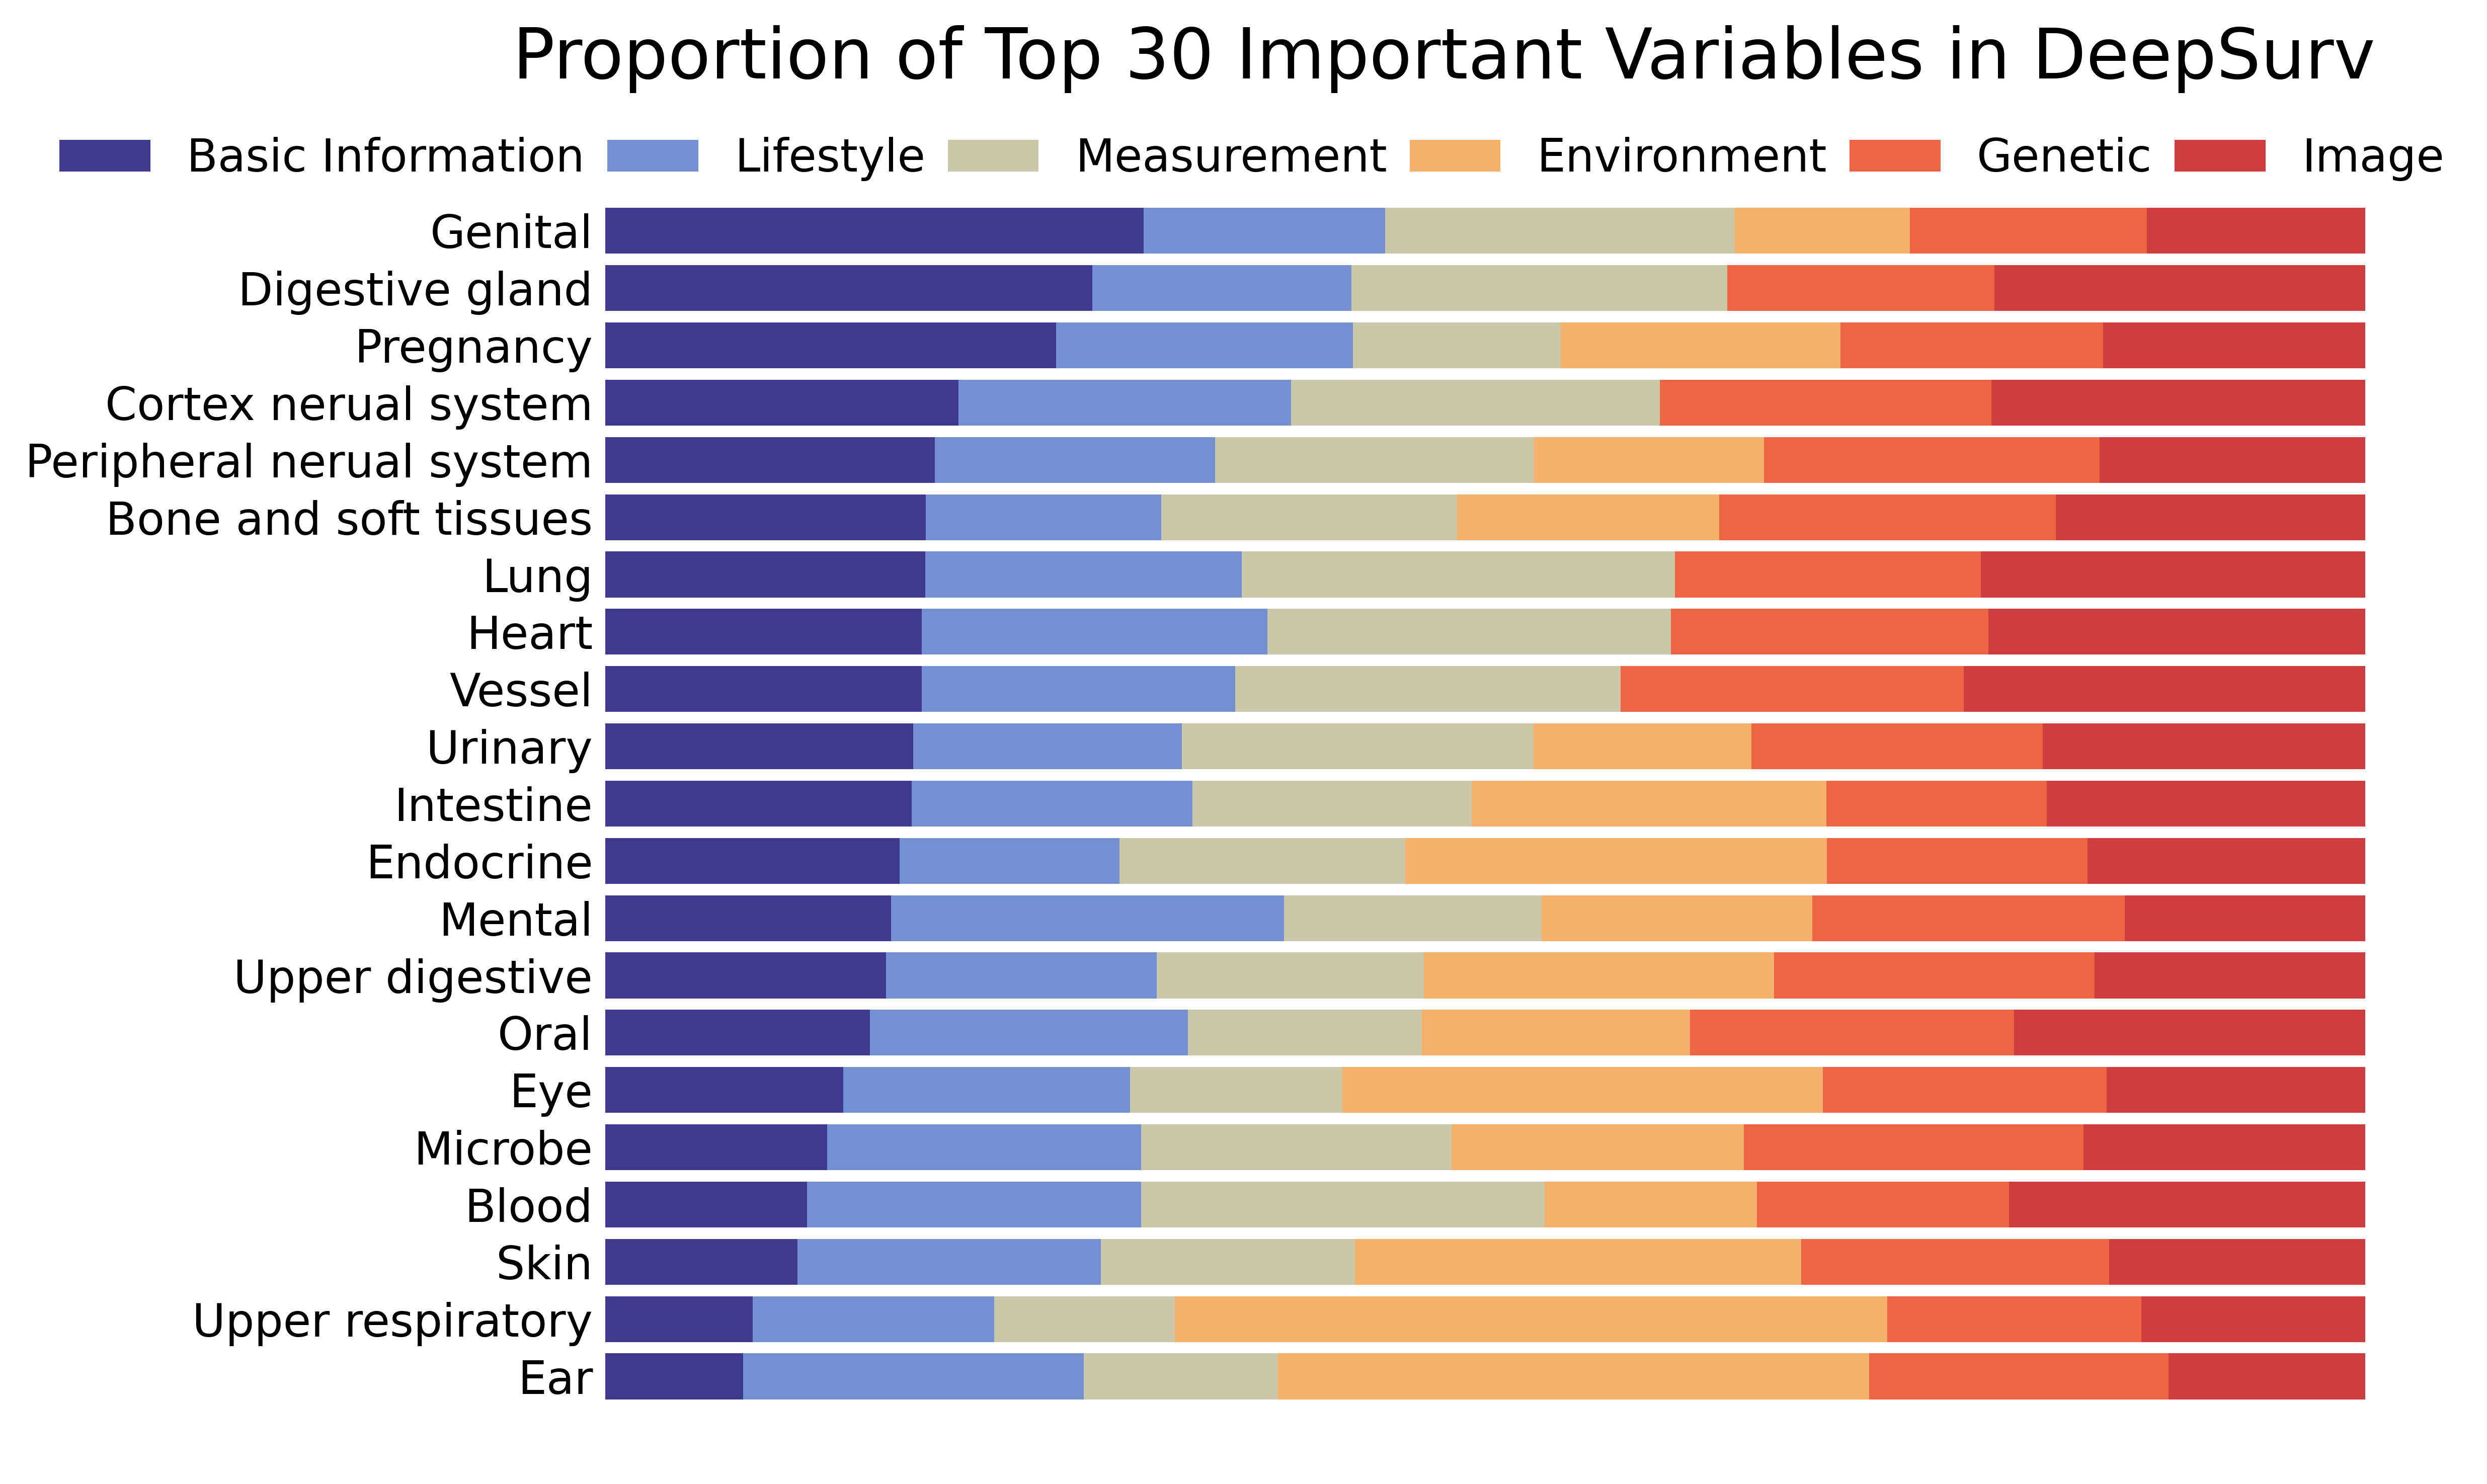

In [15]:
def find_class_top(name):
    for key, v in importancedict.items():
        if name in v.keys():
            return key
def capitalize_first_letter(input_string):
    if not input_string:
        return input_string

    first_letter = input_string[0]
    capitalized_first_letter = first_letter.upper()

    rest_of_string = input_string[1:]
    capitalized_string = capitalized_first_letter + rest_of_string

    return capitalized_string
categories = np.zeros((len(result),6))
fig = plt.figure(dpi=500,figsize=(10, 6))
mapping={'Baseline characteristics': 0,'Life': 1,  'Measures': 2, 'Natural and social environment': 3, 'Genetic': 4, 'Image': 5}
topx=30
for z in range(len(result)):
    v=list(result.values())[z]
    for i in range(topx):
        categories[z][mapping[find_class_top(v[i][0])]]+=v[i][1]
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=6)
names=[]
    
for i in np.array(list(result.keys()),dtype=str):
    
    if i=='CNS':
        names.append('Cortex nerual system')
    elif i=='PNS':
        names.append('Peripheral nerual system')
    else:
        names.append(capitalize_first_letter(i))
data_matrix = categories.T
data_matrix = (data_matrix.T / np.sum(data_matrix, axis=1)).T
data_matrix /= np.sum(data_matrix, axis=0)
index = list(np.argsort(data_matrix[0]))
data_matrix=data_matrix[:,index]
names = np.array(names)[index]
bottom = np.zeros(data_matrix.shape[1])
legend_names=['Basic Information','Lifestyle','Measurement','Environment','Genetic', 'Image']
for i in range(data_matrix.shape[0]):
    bars=plt.barh(names, data_matrix[i],label=legend_names[i], left=bottom,color=cm(i))
    bottom += data_matrix[i]
    for j,bar in enumerate(bars):
        if data_matrix[i][j]!=0:
            if False:
                plt.text(bar.get_x() + bar.get_width() / 2+0.007, bar.get_y() + bar.get_height() / 2, 
                 f'{data_matrix[i][j]*100:.1f}%', ha='center', va='center', color='black',fontsize=6)

plt.xticks([])
plt.yticks(fontsize=13)
title=f'Proportion of Top {topx} Important Variables in DeepSurv'
plt.title(title, pad=20,fontsize=20, loc="left", x=-0.05)
# t.set_position([0.5, 10])
# plt.subplot_adjust(top=0.85)
legend=plt.legend(loc='upper center',ncol=6, fontsize=13, bbox_to_anchor=(0.35, 1.04),columnspacing=0.5)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='both', length=0)
plt.savefig(temppath+title+'.pdf', format='pdf',bbox_inches="tight")

In [16]:
m = {}
for i,category in enumerate(legend_names):
    m[category]=list(data_matrix[i][::-1])
json_file_path = numericpath + title+'.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(m, f, ensure_ascii=False, indent=4)

In [17]:
topx=[5,10,20,100]
topdict={}
for t in topx:
    categories = {}
    mapping={'Baseline characteristics': 0,'Life': 1,  'Measures': 2, 'Natural and social environment': 3, 'Genetic': 4, 'Image': 5}
    for z in range(len(result)):
        v=list(result.values())[z]
        for i in range(t):
            codename=v[i][0]
            if codename in categories.keys(): 
                categories[codename]+=1
            else:
                categories[codename]=1
    topdict[t]=categories
for k,v in topdict.items():
    def s(key):
        return -topdict[k][key]
    temp={}
    for i in sorted(v,key=s):
        temp[i]=v[i]
    topdict[k]=temp

stack=np.zeros((3,15))
def s(key):
    try:
        t=(topdict[20][key]+topdict[10][key]*100+topdict[5][key]*10000)*-1
    except:
        try:
            t=(topdict[20][key]+topdict[10][key]*100)*-1
        except:
            t=(topdict[20][key])*-1
    return t
key20=sorted(list(topdict[20].keys()),key=s)

key20=key20[:15]
for k in range(3):
    for j in range(len(key20)):
        try:
            stack[k,j]=topdict[topx[k]][key20[j]]
        except:
            pass

In [18]:
colorlist=["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF",
                "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF","#FFD700FF"]
color_palette=sns.color_palette(colorlist)
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=5)
data_matrix = stack[:,::-1]
key20 = key20[::-1]

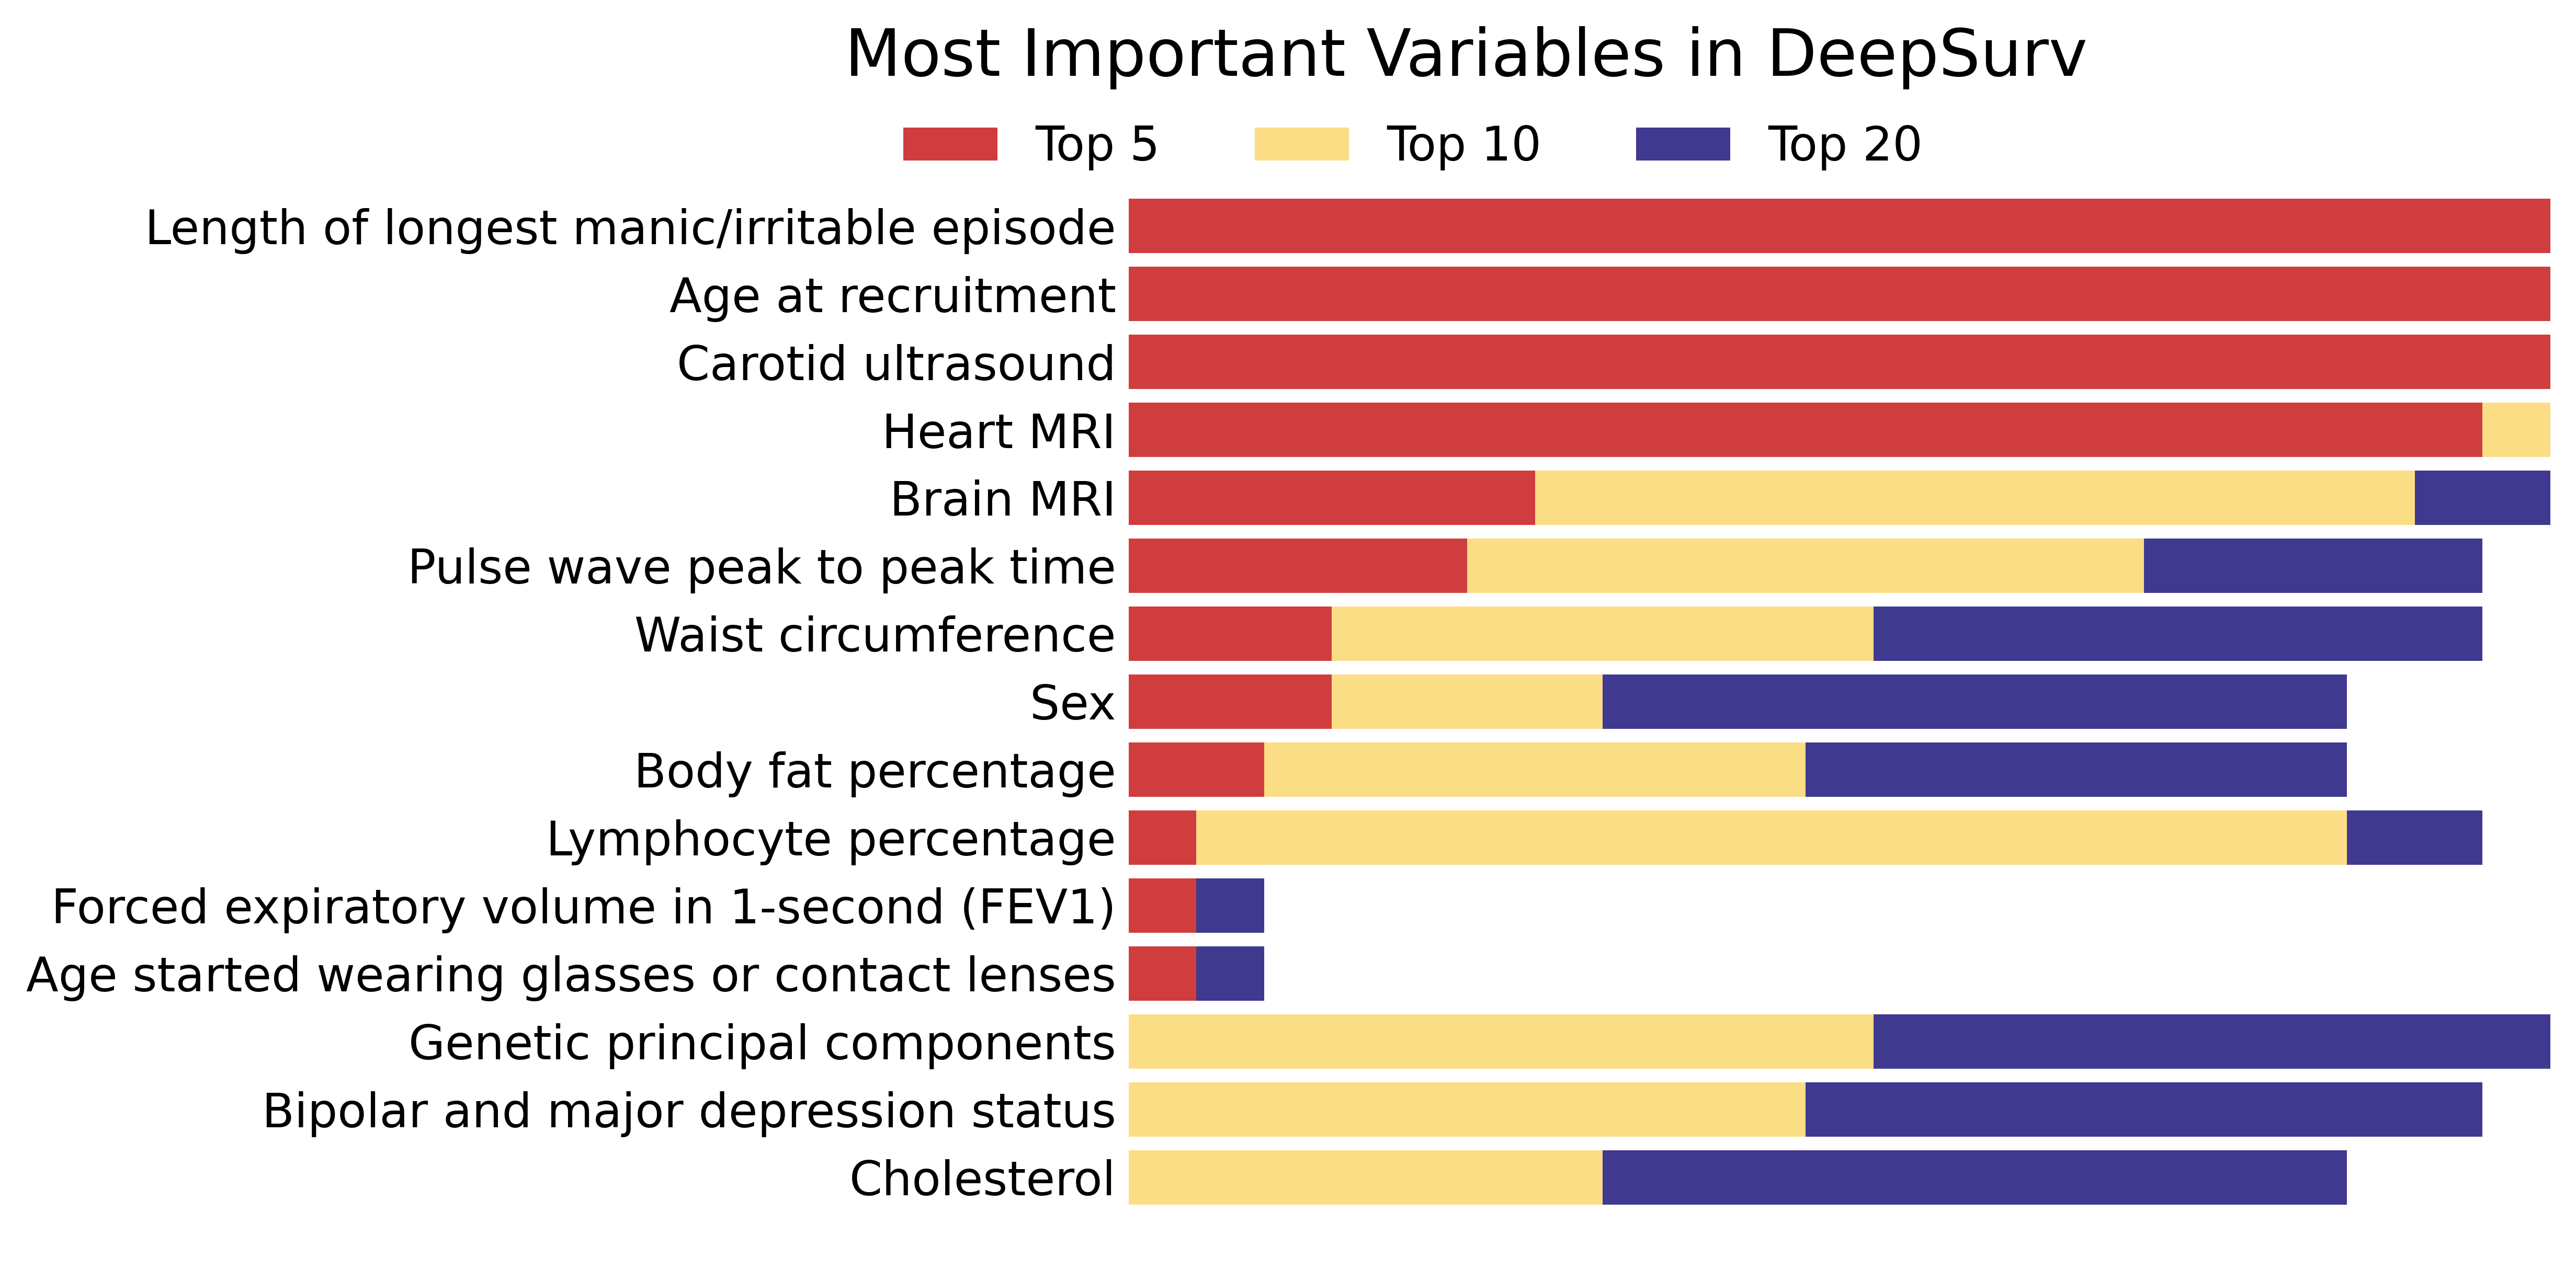

In [19]:
plt.figure(dpi=500,figsize=(10, 5))
bars=plt.barh(key20, data_matrix[0], label=f'Top {topx[0]}', left=np.zeros(data_matrix.shape[1]), color=cm(4))
for j,bar in enumerate(bars):
    if data_matrix[0][j]!=0:
        if False:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
                f'{int(data_matrix[0][j])}', ha='center', va='center', color='black',fontsize=9)
bars=plt.barh(key20, data_matrix[1] - data_matrix[0], label=f'Top {topx[1]}', left=data_matrix[0], color=cm(2))
for j,bar in enumerate(bars):
    if list(data_matrix[1] - data_matrix[0])[j]!=0:
        if False:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
                f'{int(list(data_matrix[1] - data_matrix[0])[j])}', ha='center', va='center', color='black',fontsize=9)
bars=plt.barh(key20, data_matrix[2] - data_matrix[1], label=f'Top {topx[2]}', left=data_matrix[1], color=cm(0))
for j,bar in enumerate(bars):
    if list(data_matrix[2] - data_matrix[1])[j]!=0:
        if False:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
                f'{int(list(data_matrix[2] - data_matrix[1])[j])}', ha='center', va='center', color='black',fontsize=9)
plt.yticks(fontsize=13)
plt.xticks([])
title='Most Important Variables in DeepSurv'
plt.title(title, pad=20, fontsize=18,loc='left', x=-0.2)
legend=plt.legend(loc='upper center',ncol=3, fontsize=13, bbox_to_anchor=(0.2, 1.06))
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
plt.tight_layout()
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='both', length=0)
plt.savefig(temppath + title+'.pdf', format='pdf',bbox_inches="tight")

In [20]:
m = {}
for key in topdict.keys():
    if key==5:
        m[key] = list(data_matrix[0][::-1])
    if key==10:
        m[key] = list((data_matrix[1] - data_matrix[0])[::-1])
    if key==20:
        m[key] = list((data_matrix[2] - data_matrix[1])[::-1])
json_file_path = numericpath + title+'.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(m, f, ensure_ascii=False, indent=4)

In [21]:
def find_min_max(cold):
    data = [np.mean(gs[:,coldata.index(x)]) for x in cold]
    return (np.min(data), np.max(data))
def find_sort(cold):
    data = [np.mean((gs[:,coldata.index(x)])) for x in cold]
    return np.argsort(np.array(data))
def draw_single(ax, colname, title, minvalue, maxvalue, xticks=None):
    index = coldata.index(colname)
    data = gs[:,index]
    dat = pd.DataFrame({'data': data})
    '#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E'
    colors = [(0, '#403990'), (0.25, '#80A6E2'), (0.5, '#FBDD85'), (0.75, '#F46F43'), (1, '#CF3D3E')]
    cmap = LinearSegmentedColormap.from_list('custom', colors)
    # print(cmap(0),cmap(1))
    print(np.mean(data))
    if np.mean(data) >= 0:
        mapcolor = 0.5 * np.mean(data) / maxvalue + 0.5
    else:
        mapcolor = - 0.5 * np.mean(data) / minvalue + 0.5
    sns.kdeplot(data=dat, x='data', fill=True, ax=ax, color=cmap(mapcolor))
    ax.set_title(title, fontsize=10)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    # plt.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis="both", which='both', labelsize=8)
    ax.set_yticks(ticks=[], labels='')
    ax.set_ylabel("")
    ax.set_xlabel("")
    # plt.xticks(fontsize=5)
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.axvline(x=0, color='grey', linestyle='--')

-0.007413104
-0.0053076902
-0.0032139372
-0.0014380242
-0.0009668044
-0.0006743919
0.00057689287
0.0016675107
0.0017192471
0.004345248
0.0057135485
0.03228802


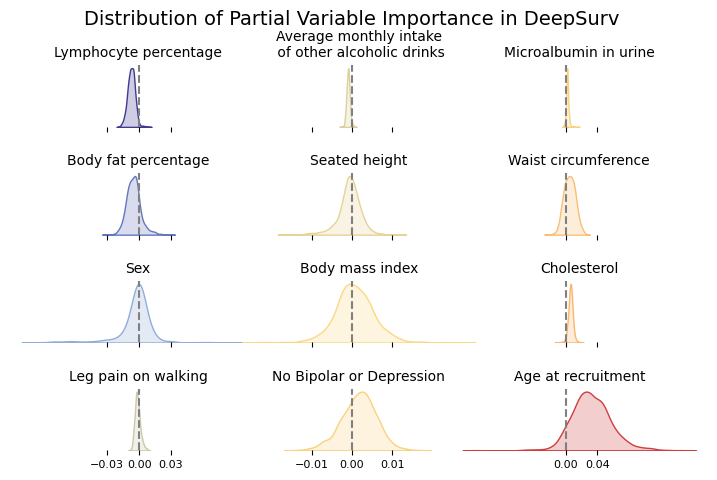

In [30]:
names = ['Waist circumference', 'Seated height', 
         'No Bipolar or Depression', 'Body mass index', 
         'Body fat percentage', 'Average monthly intake\n of other alcoholic drinks', 'Sex', 'Age at recruitment', 'Microalbumin in urine', 
          'Lymphocyte percentage', 'Cholesterol', 'Leg pain on walking']
cold = ['48', '51', '20126#0', '21001', '23099', '4462', '31#1', '21022', '30500', '30180', '30690', '4728#1']
title="Distribution of Partial Variable Importance in DeepSurv"
minvalue, maxvalue = find_min_max(cold)
sortlist = find_sort(cold)
fig, axes = plt.subplots(4, 3, sharex='col', gridspec_kw={'height_ratios': [1, 1, 1, 1], 'wspace': -0.14, 'hspace':0.75}, figsize=(9, 5))
draw_single(axes[0,0], cold[sortlist[0]], names[sortlist[0]], minvalue, maxvalue)
draw_single(axes[1,0], cold[sortlist[1]], names[sortlist[1]], minvalue, maxvalue)
axes[0,1].text(0,1720,title, ha='center', fontsize=14)
draw_single(axes[2,0], cold[sortlist[2]], names[sortlist[2]], minvalue, maxvalue)
draw_single(axes[3,0], cold[sortlist[3]], names[sortlist[3]], minvalue, maxvalue, [-0.03, 0, 0.03])
draw_single(axes[0,1], cold[sortlist[4]], names[sortlist[4]], minvalue, maxvalue)
draw_single(axes[1,1], cold[sortlist[5]], names[sortlist[5]], minvalue, maxvalue)
draw_single(axes[2,1], cold[sortlist[6]], names[sortlist[6]], minvalue, maxvalue)
draw_single(axes[3,1], cold[sortlist[7]], names[sortlist[7]], minvalue, maxvalue, [-0.01, 0, 0.01])
draw_single(axes[0,2], cold[sortlist[8]], names[sortlist[8]], minvalue, maxvalue)
draw_single(axes[1,2], cold[sortlist[9]], names[sortlist[9]], minvalue, maxvalue)
draw_single(axes[2,2], cold[sortlist[10]], names[sortlist[10]], minvalue, maxvalue)
draw_single(axes[3,2], cold[sortlist[11]], names[sortlist[11]], minvalue, maxvalue, [0,  0.04])
plt.savefig(temppath + title+'.pdf', format='pdf',bbox_inches="tight")

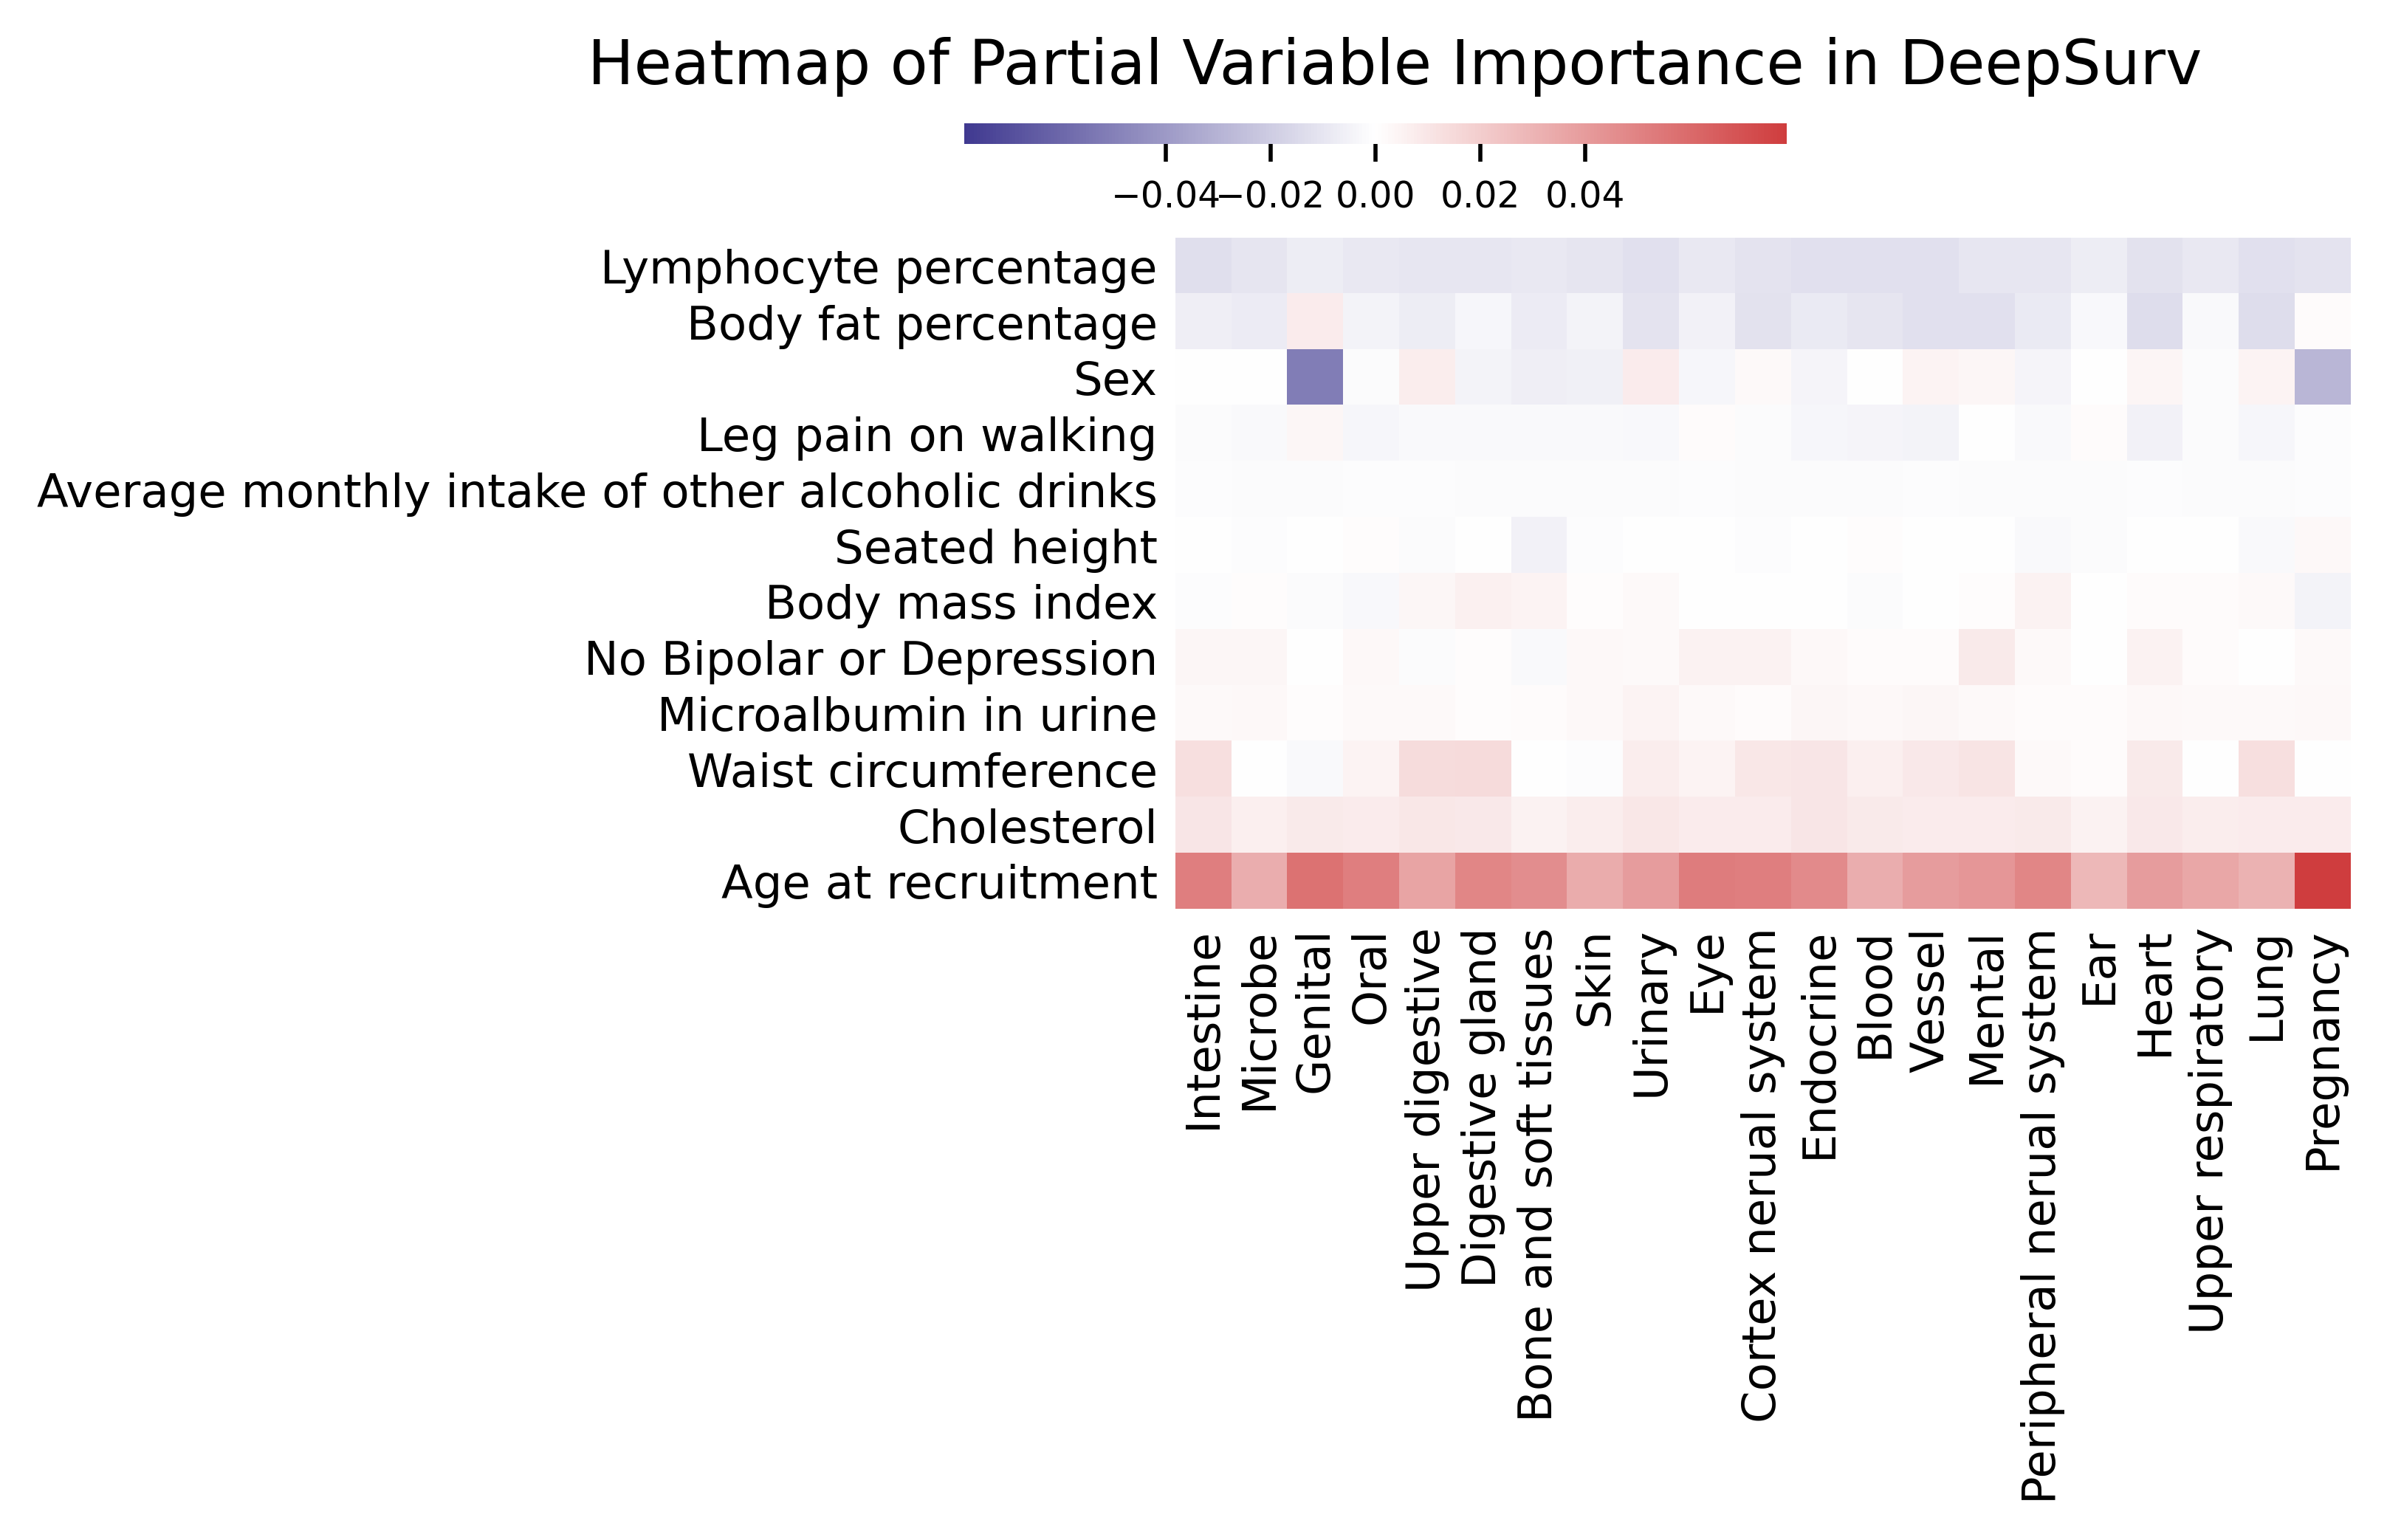

In [31]:
sumdata={}
for cat in phecat.keys():
    sumdata[cat]=np.array(gs[phecat[cat],:]).sum(0)
    sumdata[cat] = sumdata[cat] / np.linalg.norm(sumdata[cat], ord=1)
index = np.array([coldata.index(cold[sortlist[i]]) for i in range(len(sortlist))])
nmes = [nme.replace('\n', '') for nme in names]
mtxs = []
for key, value in sumdata.items():
    mtxs.append(value[index])
matrix = np.vstack(mtxs).T
x_labels = list(phecat.keys())
plt.figure(dpi=500, )
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
# colors = ['#FFFFFF','#F46F43','#CF3D3E']
colors = ['#403990', '#FFFFFF','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors)
heatmap = plt.imshow(matrix, cmap=cm, vmin=-np.max(np.abs(matrix)), vmax=np.max(np.abs(matrix)))
cbar=plt.colorbar(heatmap, shrink=0.7, orientation='horizontal', aspect=40, anchor=(-0.6,6.8))
cbar.ax.tick_params(labelsize=7)
cbar.set_ticks([-0.04,-0.02, 0, 0.02, 0.04, ])
cbar.outline.set_visible(False)
y_labels = list(sumdata.keys())
for i in range(len(x_labels)):
    x_labels[i]=capitalize_first_letter(x_labels[i])
for i in range(len(y_labels)):
    y_labels[i]=capitalize_first_letter(y_labels[i])
    if y_labels[i]=='CNS':
        y_labels[i]='Cortex nerual system'
    if y_labels[i]=='PNS':
        y_labels[i]='Peripheral nerual system'
plt.xticks(np.arange(matrix.shape[1]), y_labels, rotation=90,fontsize=9)
plt.yticks(np.arange(matrix.shape[0]),np.array(nmes)[sortlist] ,fontsize=9)
title='Heatmap of Partial Variable Importance in DeepSurv'
plt.title(title,fontsize=12, pad=30, loc="left", x=-0.5)
plt.tight_layout()
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='both', length=0)
plt.savefig(temppath + title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()